# Spiking KNN Implementation in Lava

This is a partial implementation of the following paper:

[Neuromophic Nearest-Neigbor Search Using Intel's Pohoiki Springs](https://arxiv.org/abs/2004.12691)

by E. Paxon Frady and authors

# Background

KNN (K Nearest Neigbor) is a common ml problem in which a query data instance is compared to keys in a database to find the K best matches. 

If the query can be represented as a sparse data stream we stand to gain benefits in efficiency when deployed to specialized hardware. The parallism of modern neuromorphic chips like loihi2 could also provide benefits.

In this notebook we ran a CPU driven KNN experiment followed by a Spiking KNN implementation. 

In this experiment, queries and keys are represented via HOG feature maps to ensure a sparse representation.


# Standard KNN Search
We choose a query image which is a watermelon. Ideally, if the KNN search works the watermelon should closely 
match other watermelons in the database. Our similarity metric will be cosine_similarity score, where matching images have a similarity score of 1 and non matching images will have a similarity score of 0. 

In [22]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

import numpy as np
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity

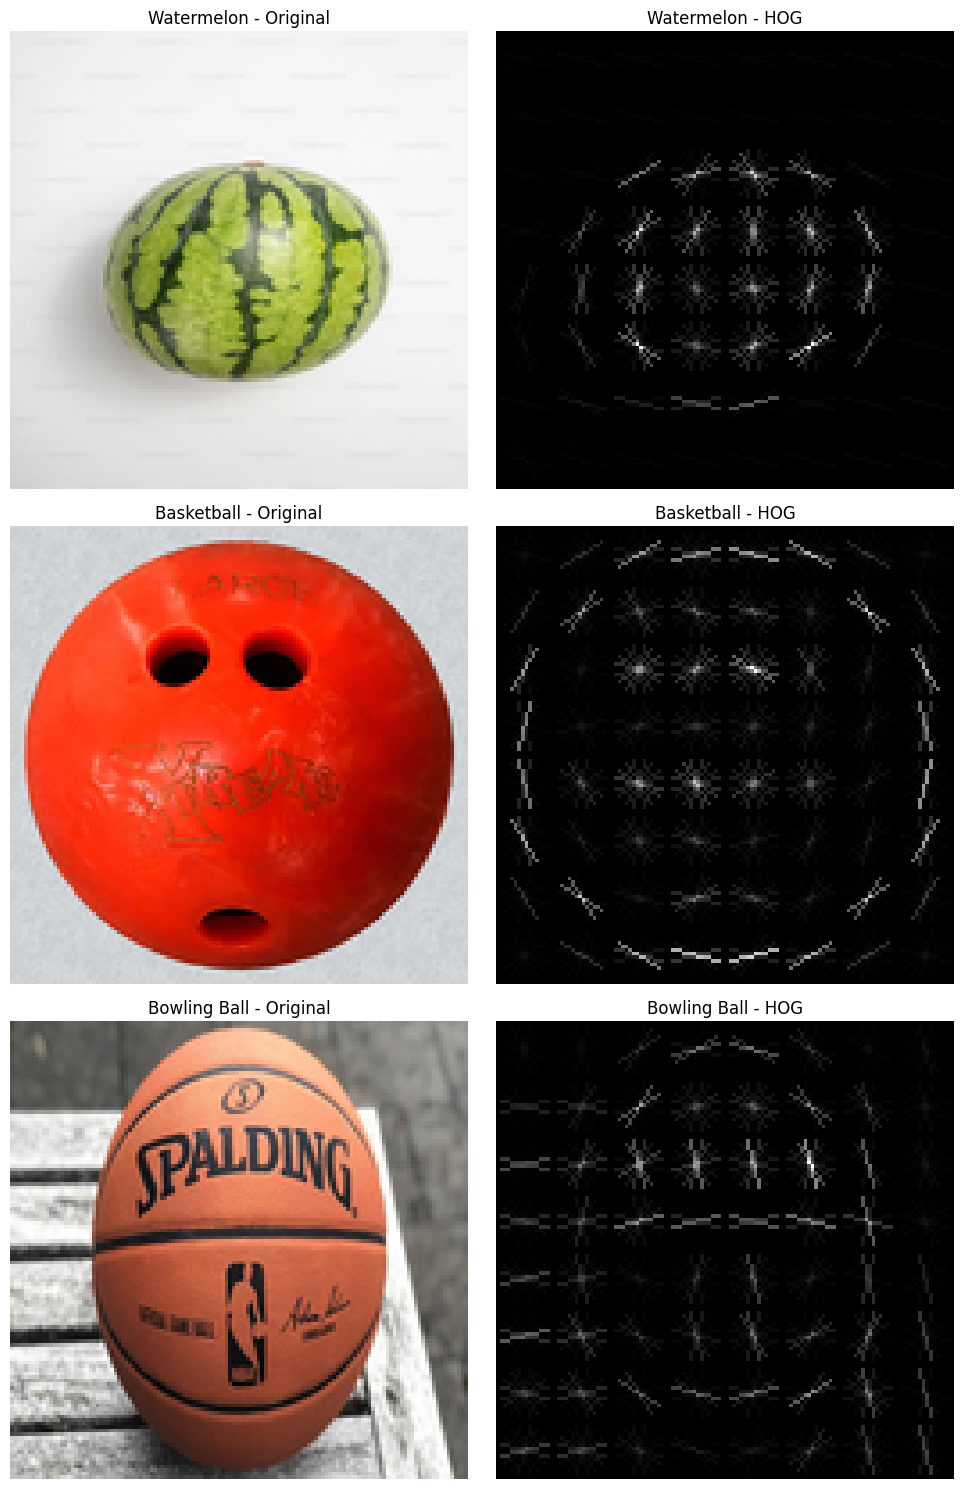

In [23]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt

# Define the target dimensions
target_dimension = (128, 128)

# Function to download and process an image
def process_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize(target_dimension, Image.LANCZOS)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return fd, img, hog_image

# URLs of images
watermelon_url = 'https://plus.unsplash.com/premium_photo-1724849424575-2192d59e06f7?q=80&w=1287&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
basketball_url = 'https://upload.wikimedia.org/wikipedia/commons/4/44/20190118A_Plastic_house_bowling_ball_conventional_grip.jpg'
bowling_ball_url = 'https://upload.wikimedia.org/wikipedia/commons/b/bb/Spalding_Basketball.jpg'

# Process each image
fd1, database_image1, hog_image1 = process_image(watermelon_url)
fd2, database_image2, hog_image2 = process_image(basketball_url)
fd3, database_image3, hog_image3 = process_image(bowling_ball_url)

# Set up the plot
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # 3 rows for images, 2 columns for raw and HOG images

# List of images and titles
images = [(database_image1, hog_image1), (database_image2, hog_image2), (database_image3, hog_image3)]
titles = ["Watermelon", "Basketball", "Bowling Ball"]

# Plot each image and its HOG side-by-side
for i, (img, hog_img) in enumerate(images):
    # Plot original image
    axs[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    axs[i, 0].set_title(f"{titles[i]} - Original")
    axs[i, 0].axis("off")
    
    # Plot HOG image
    axs[i, 1].imshow(hog_img, cmap='gray')
    axs[i, 1].set_title(f"{titles[i]} - HOG")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()


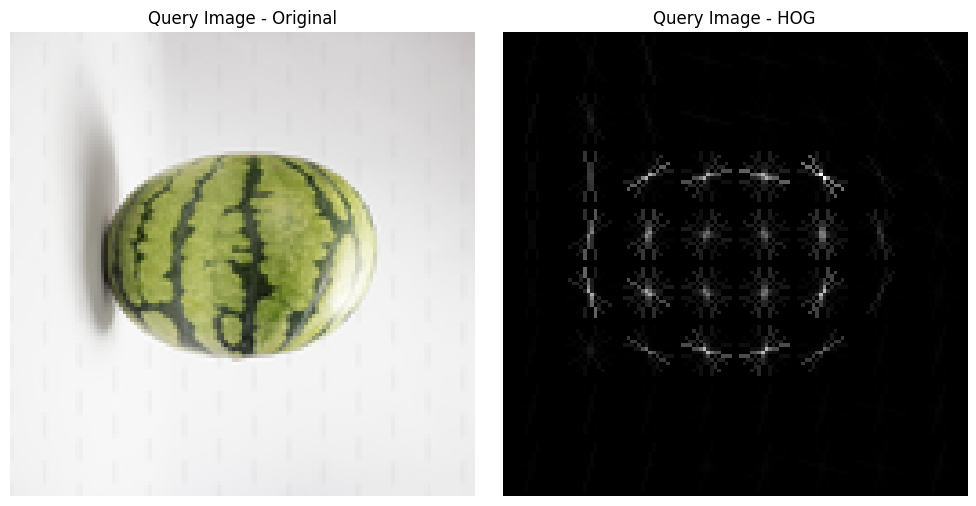

In [24]:
# Choose query image
fd, query_image, hog_query = process_image("https://plus.unsplash.com/premium_photo-1724849424601-56d2b5dfd606?q=80&w=1170&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
query_image = cv2.rotate(query_image, cv2.ROTATE_90_CLOCKWISE)
hog_query = np.rot90(hog_query, -1) 

# Plotting the selected query image (Watermelon) and its HOG side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original image
axs[0].imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
axs[0].set_title("Query Image - Original")
axs[0].axis("off")

# Plot HOG image
axs[1].imshow(hog_query, cmap='gray')
axs[1].set_title("Query Image - HOG")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Now lets compare the query hog features against the database of hog features. We should expect to see that the two watermelons share the highest cosine_similarity

In [25]:
# Flatten the HOG feature arrays for comparison
hog_query_flat = hog_query.flatten()
hog_image1_flat = hog_image1.flatten()
hog_image2_flat = hog_image2.flatten()
hog_image3_flat = hog_image3.flatten()

# Calculate and print cosine similarity scores
print("Comparison 1 score:", cosine_similarity([hog_query_flat], [hog_image1_flat])[0][0])
print("Comparison 2 score:", cosine_similarity([hog_query_flat], [hog_image2_flat])[0][0])
print("Comparison 3 score:", cosine_similarity([hog_query_flat], [hog_image3_flat])[0][0])

Comparison 1 score: 0.8057300461455974
Comparison 2 score: 0.40281674022502695
Comparison 3 score: 0.482740256814534


As we can see here the two watermelons have the highest match score. Obviously this type of KNN search is not rotation, scale, or translation invariant.
The authors of the original paper do not use HOG features, but rather a combination of PCA and ICA to create a sparse encoding matrix for each image.



# Spiking KNN

In the Spiking KNN paper the authors denote feature i of a query as $e_i$. Each feature creates a single spike and the magnitude of the feature determines when the spike occurs. 

$$
\tilde{s}_i(t) = 
\begin{cases} 
\delta \left( t - T \left(1 - \frac{\tilde{e}_i}{\tilde{e}_{\text{max}}} \right) \right) & \text{if } \tilde{e}_i > \theta_e \\[10pt]
0 & \text{otherwise}
\end{cases}
$$

$e_\text{max}$ is the largest possible feature value and $\theta_e$ is a cutoff to exclude small feature values. We exclude negative feature values for our implementation but those are included in the paper. 

We next encode the hog query database by directly translating them into neural network weights. The only requirement is that every hog feature has to be normalized beforehand. 

The goal for our Spiking Neurons is for the voltage of the neuron to act as a similarity score which updates over time as evidence is accumulated. We want the threshold of the neuron to act as an early stopping criteria which tells the user when a match is found so that we can stop the search early. 

This behavior is accomplished via a second order lif neuron without voltage or current decay. In other words, a neuron which acts as a *perfect integrator*:  

$$
U_i(t+1) = U_i(t) + \sum_j W_{ij} \tilde{s}_j(t)
$$

$$
V_i(t+1) = V_i(t) + U_i(t)
$$

Consider the following figure from the paper:

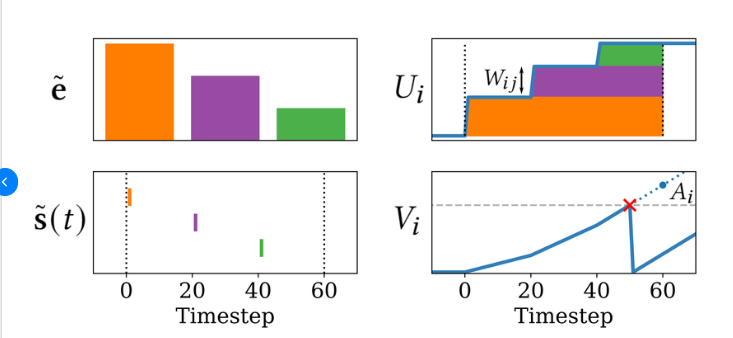

As you can see in the above graphic, the reason why earlier spikes correspond to greater valued features is because there is no current decay. The longer the simulation runs, the longer the undecayed current contributes to the voltage.


In [26]:
# Lets convert the query image into a spike train according to the papers implementation
T = 60
e_max =   np.max(hog_query)
spike_query = np.zeros((hog_query.size, T))
t_list = []
for idx, feature in enumerate(hog_query_flat):
    if feature == 0: # our theta_e is 0 in this case
        continue
    timestep = int(np.round(T * (1 - feature/e_max)))
    if timestep == 60:
        continue # feature cannot make a difference
    t_list.append(timestep)
    spike_query[idx, timestep] = 1

In [27]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor
from lava.proc.io.source import RingBuffer as RingBufferSend
from lava.proc.io.sink import RingBuffer as RingBufferReceive
from lava.proc.lif.process import LIF
from lava.proc.sparse.process import Sparse

# Three comparisons because of 3 neurons
n_neurons = 3
neurons = LIF(shape = (n_neurons, ), du = 0, dv = 0, vth = 100) # perfect integrator neurons

weight_matrix = np.zeros((3, hog_query.size))
weight_matrix[0] = hog_image1_flat/norm(hog_image1_flat)
weight_matrix[1] = hog_image2_flat/norm(hog_image2_flat)
weight_matrix[2] = hog_image3_flat/norm(hog_image3_flat)
sparse = Sparse(weights = weight_matrix) # use a sparse matrix since it would be more efficient on chip
print("Sparsity of weight matrix", (weight_matrix == 0).sum()/np.prod(np.shape(weight_matrix)))

incoming_spike_data = np.stack(spike_query)
incoming_data_process = RingBufferSend(data = incoming_spike_data)
incoming_data_process.out_ports.s_out.connect(sparse.s_in)
sparse.a_out.connect(neurons.a_in)

# monitor the voltage of the neuron
monitor = Monitor()
monitor.probe(target = neurons.v, num_steps = T) # create a probe to observe voltage

# Create a container for neuron output spikes
outgoing_data_process = RingBufferReceive(shape= (3, ), buffer = T)
neurons.s_out.connect(outgoing_data_process.a_in)

# Run Simulation
run_config = Loihi1SimCfg()
# run our simulation for n_steps
neurons.run(condition=RunSteps(num_steps=T, blocking=True), run_cfg=run_config)
probe_data_volt = monitor.get_data()[neurons.name]["v"]
probe_data_spike = outgoing_data_process.data.get()
neurons.stop()

Sparsity of weight matrix 0.6787923177083334


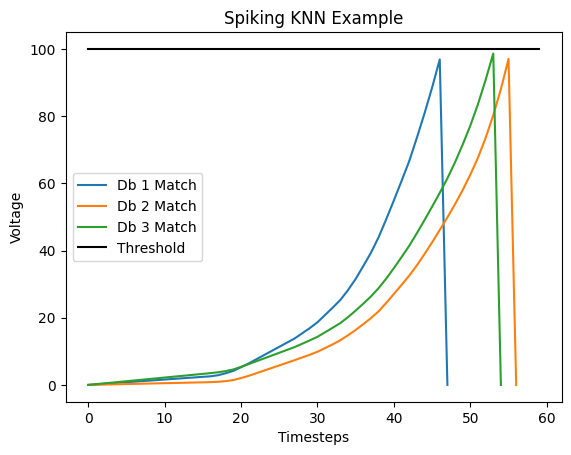

In [28]:
db1_spike = int(np.argwhere(probe_data_spike[0, :])[0])
db1_volt = probe_data_volt[:db1_spike+1, 0]

db2_spike = int(np.argwhere(probe_data_spike[1, :])[0])
db2_volt = probe_data_volt[:db2_spike+1, 1]

db3_spike = int(np.argwhere(probe_data_spike[2, :])[0])
db3_volt = probe_data_volt[:db3_spike+1, 2]

# Plot each database's voltage data up to its spike time
plt.plot(np.arange(len(db1_volt)), db1_volt, label="Db 1 Match")
plt.plot(np.arange(len(db2_volt)), db2_volt, label="Db 2 Match")
plt.plot(np.arange(len(db3_volt)), db3_volt, label="Db 3 Match")

# Add threshold line for comparison
plt.plot(np.arange(T), [100] * T, label="Threshold", color="black")

# Plot settings
plt.title("Spiking KNN Example")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("Voltage")
plt.show()

Notice How 

# Conceptual Question
1. Why are we normalizing the hog feature maps before translating them into the weight matrix? (Hint: look at the mathematical definition of cosine similarity)

# 